## GMM

### Importing basic libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MCMC_DZ.MCMC.Visualization_tools as Vts
import MCMC_DZ.MCMC.Statistic_tools as Sts
from MCMC_DZ.MCMC.MetropolisHastingMCMC.MHMC import MHMC
import MCMC_DZ.MCMC.MetropolisHastingMCMC.ProposalDistributions as PDs
from MCMC_DZ.BayesianInference.Likelihood_functions import GMM

### The pdf function

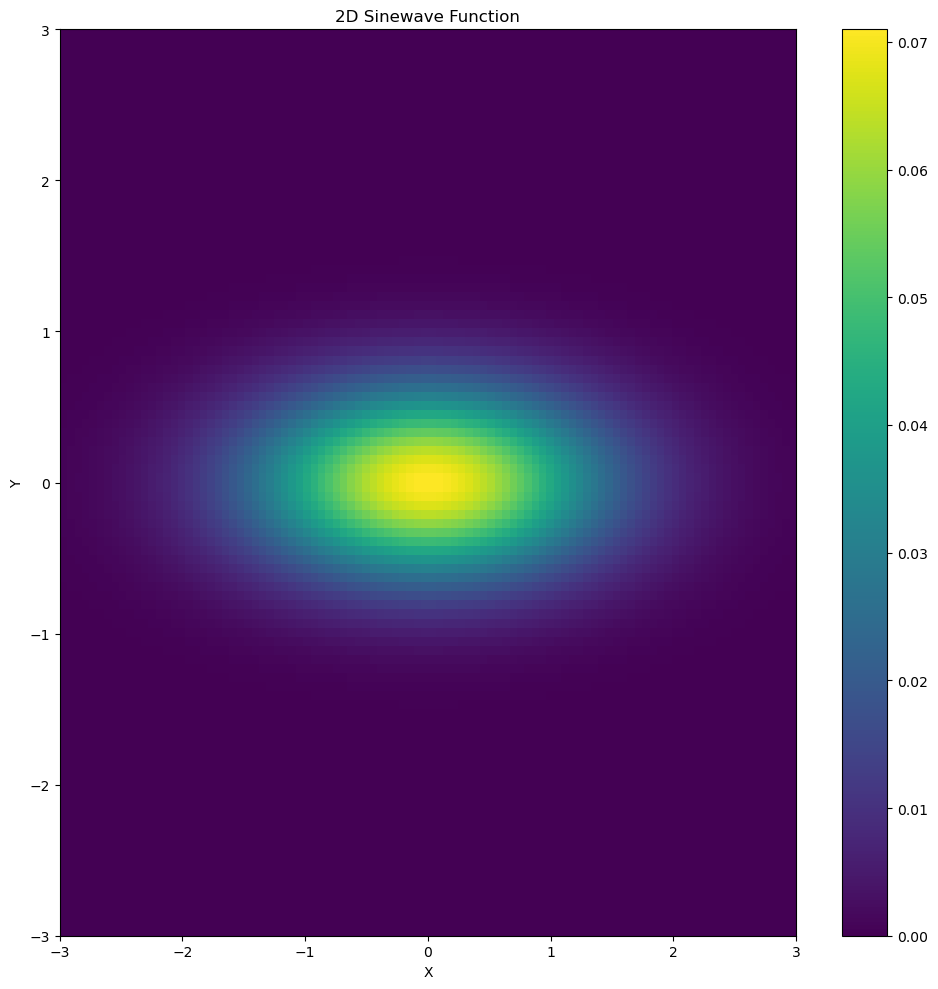

In [2]:
Data_range = np.array([[-3, 3], [-3, 3]])
Sigma =  np.asarray([[1, 0], [0, 0.2]])
pdf = GMM.Gaussian_PDF(params=np.asarray([0,0]), Sigma=Sigma)
Vts.Target_Distribution_Visualization(X_range=Data_range[0], Y_range=Data_range[1], Tar_Dis=pdf.f, Func_name="2D Sinewave Function", alpha=1)

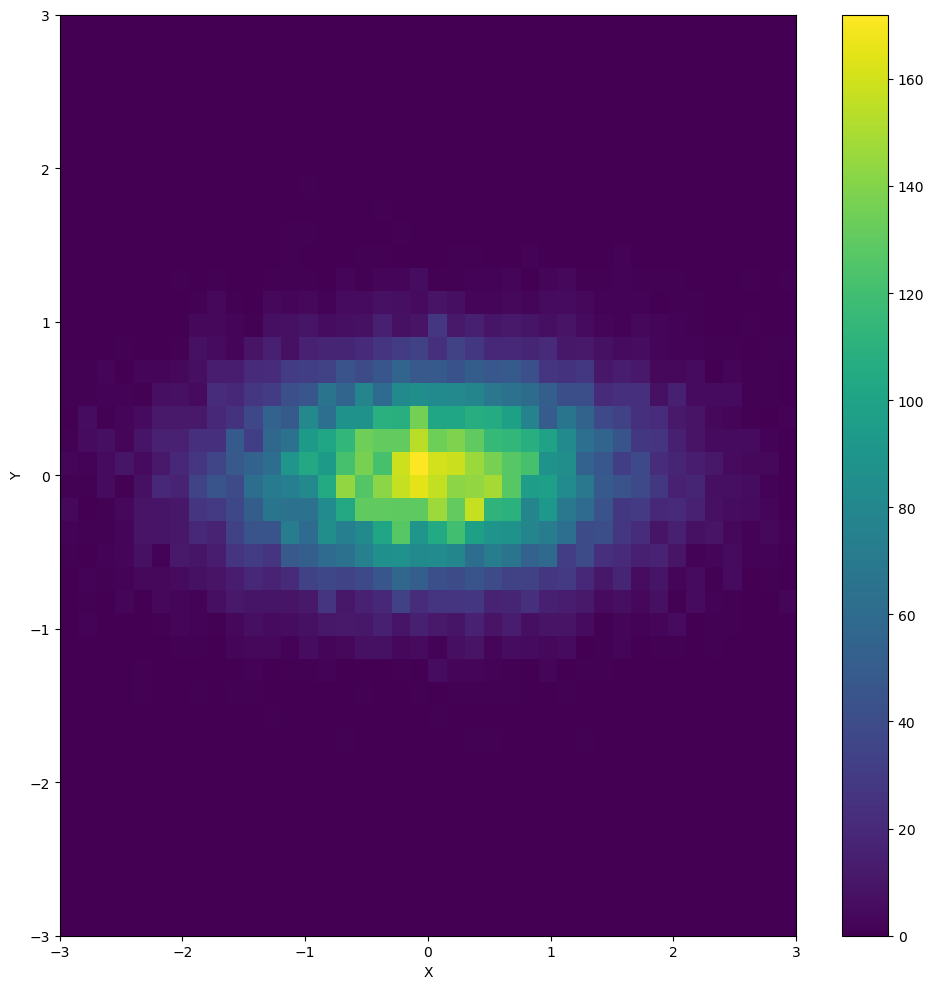

In [3]:
FD = Sts.FakeDataGen2D_Poisson(pdf.f, Data_range, 40, scaler=100000)


Vts.PlotHeatmap(FD.x , FD.y, FD.BinsValue.reshape(FD.x.shape), xlabel="X", ylabel="Y", zlabel="F(X,Y)")

In [4]:
L_Gen = Sts.LikeliFuncGen_ContinuousPoisson(FD, pdf)

In [5]:
def PlotHeatmap(x, y, z, xlabel, ylabel, zlabel, Plot_Max=False, Plot3D=False):
    if Plot3D:
        # Creat the surface plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x, y, z, cmap='viridis', alpha=1)
        fig.colorbar(ax.plot_surface(x, y, z, cmap='viridis'))
        max_idx = np.argmax(z)
        if Plot_Max:
            row = int(max_idx/z.shape[1])
            col = int(max_idx%z.shape[1])
            x_max = x[row, col]
            y_max = y[row, col]
            z_max = z[row, col]
            ax.scatter(x_max, y_max, z_max, c='red', marker='o', linewidths=2, label=f"The Maxumum likelihood point ({xlabel}, {ylabel}) = ({x_max:.3f}, {y_max:.3f})")
            ax.legend()

        # Set the plot title and axis labels
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
    else:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.imshow(z, cmap='viridis', origin="lower", extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', vmin=np.min(z)+(np.max(z)-np.min(z))*0.3)
        fig.colorbar(ax.imshow(z, cmap='viridis', origin="lower", extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', vmin=np.min(z)+(np.max(z)-np.min(z))*0.3))
        max_idx = np.argmax(z)
        if Plot_Max:
            x_max = x[max_idx//z.shape[1], max_idx%z.shape[1]]
            y_max = y[max_idx//z.shape[1], max_idx%z.shape[1]]
            ax.scatter(x_max, y_max, c='red', marker='o', linewidths=2, label=f"The Maxumum likelihood point ({xlabel}, {ylabel}) = ({x_max:.3f}, {y_max:.3f})")
            ax.legend()

        # Set the plot title and axis labels
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

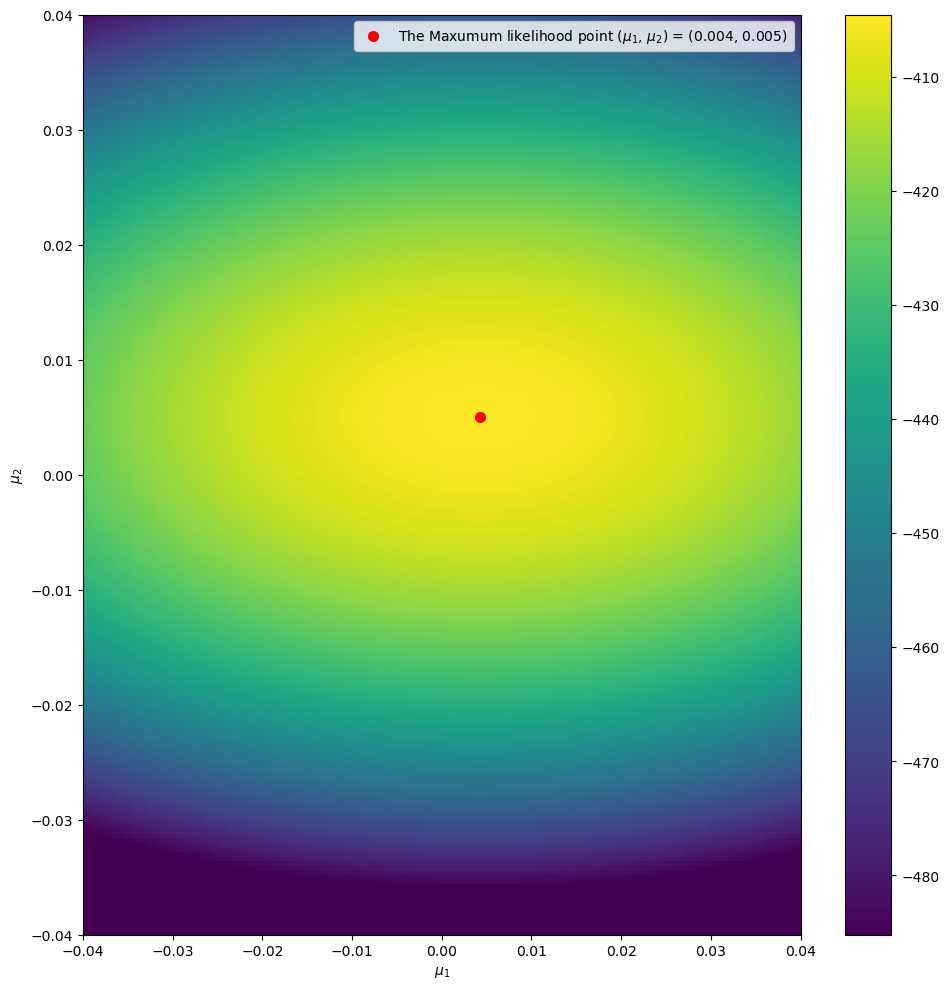

In [6]:
mu1s = np.linspace(-0.04, 0.04, 200)
mu2s = np.linspace(-0.04, 0.04, 200)
mu1s, mu2s= np.meshgrid(mu1s, mu2s)

Ls = []
for params in zip(mu1s.flatten(), mu2s.flatten()):
    Ls.append(L_Gen.Log_Likelihood(np.asarray(params)))

Ls = np.asarray(Ls).reshape(mu1s.shape)
PlotHeatmap(mu1s, mu2s, Ls, xlabel="$\mu_1$", ylabel="$\mu_2$", zlabel="l($\mu_1$, $\mu_2$)", Plot_Max=True)

## Metropolis-Hasting MCMC

### Initializing the list to collect the outputs of the MCMC algorithm

In [19]:
Res = []

In [20]:
# Loading the pre outputs
data_folder = "Datas/Data_40bins_100000scale_Gaussian/"
for name in os.listdir(data_folder):
    data_dir = os.path.join(data_folder, name)
    Res.append(Sts.Loading_Data(data_dir))

### Applying MCMC algorithm on the likelihood funciton

In [31]:
steps = 1000000

In [34]:
# for sd in [[0.01, 0.02], [0.02, 0.04], [0.04, 0.08]]:
sd = [0.001, 0.001]
Prop_G = PDs.GaussianProposalDistribution(sd=sd, Dim=2)
MHMC_SF = MHMC(rho=L_Gen.Log_Likelihood, log_likelihood=True)
Res_G = MHMC_SF.generate(
    theta0=[0.5 for _ in range(2)], 
    ProposalFunction=Prop_G,
    steps=steps,
    OutputRunTime=100,
    MaxTime=4000
)
Res.append(Res_G)

In [30]:
for k in range(len(Res)):
    sd = Res[k]["PD_sd"]
    Saving_dir = f"Datas/Data_40bins_100000scale_Gaussian/Res_G(sd={sd}).npz"
    Sts.Saving_Data(Res[k], FileName=Saving_dir)

In [33]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    Vts.density_plot(
        Res_G_SF["Thetas"][:1000000], 
        bins=50,
        burn_in=10000,
        credible_region=0,
        x_name="B",
        y_name="C",
        label = f" with sd = {sd}",
        alpha=1,
    )

c:\Users\91464\Nutstore\1\Nutstore\MLBD\PHYS70023\Coding\MCMC_DZ\MCMC\Visualization_tools.py:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


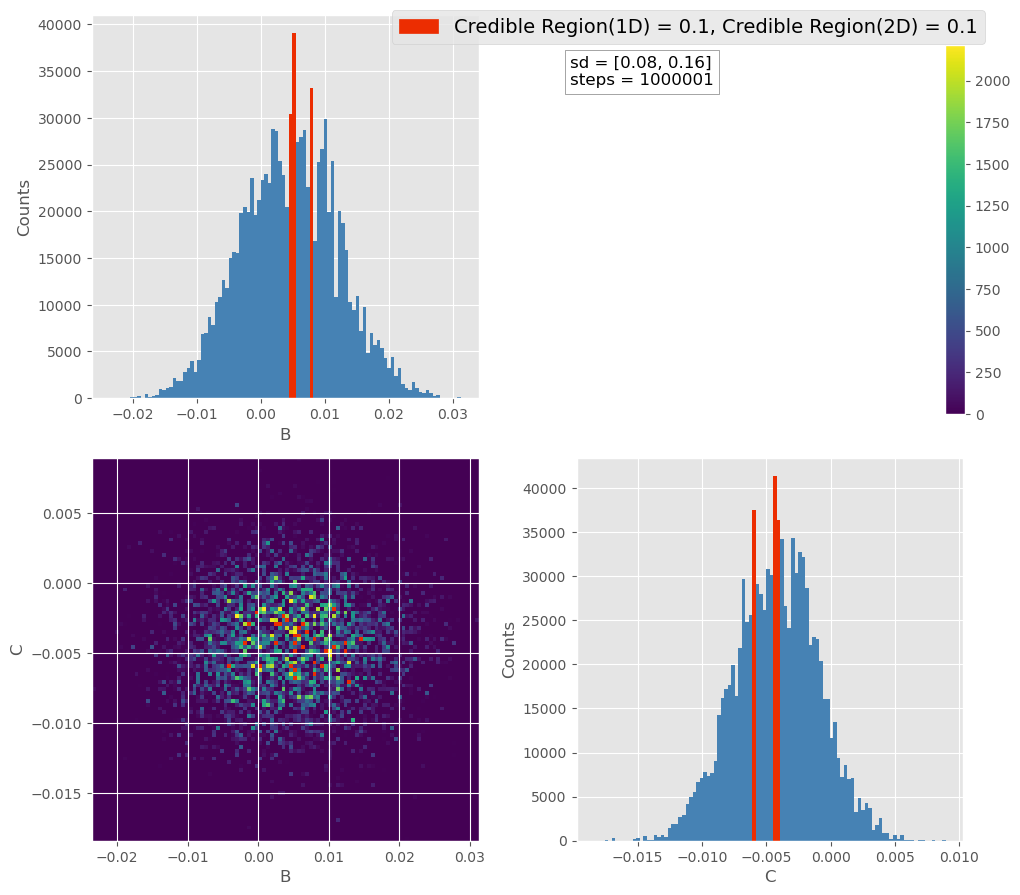

In [67]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    steps = Res_G_SF["Thetas"].shape[0]
    _ = Vts.density_plots(
        Res_G_SF["Thetas"],
        plot_axis=[0, 1],
        bins=100,
        burn_in=5000,
        axis_name=["B", "C"],
        cr_1D=0.1,
        cr_2D=0.1,
        information=f"sd = {sd}\nsteps = {steps}"
    )


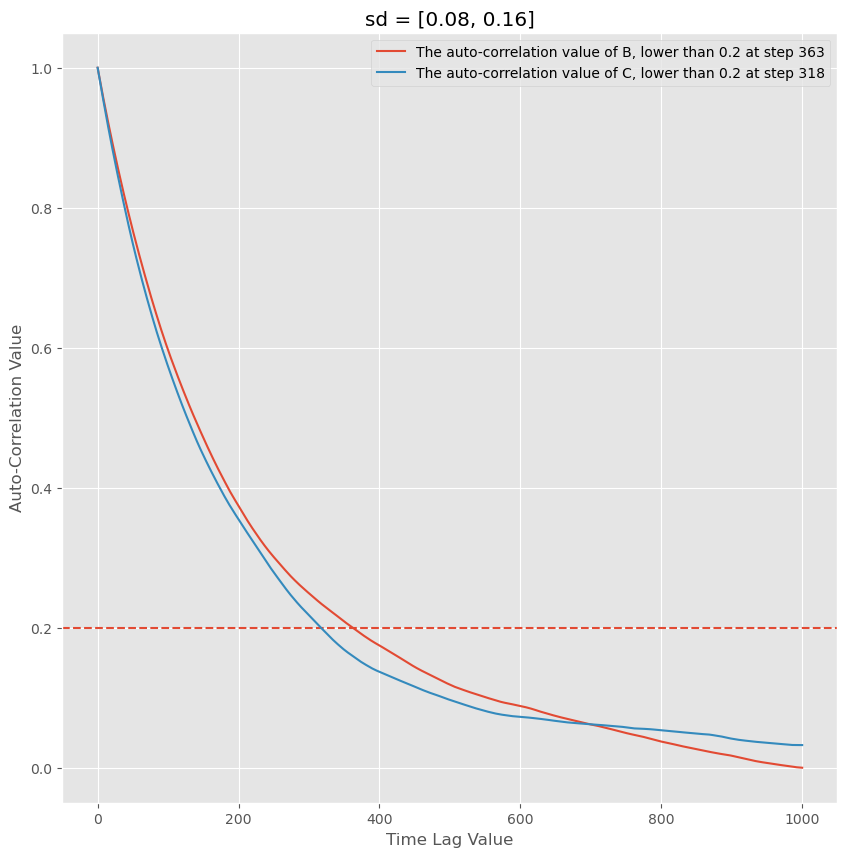

In [68]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    Vts.auto_corr_plot(Thetas=Res_G_SF["Thetas"], plot_nth_theta=[0,1], theta_index=["B", "C"], max_time_lag=1000, data_range=[1000, steps], Threshold=0.2, set_title=f"sd = {sd}")

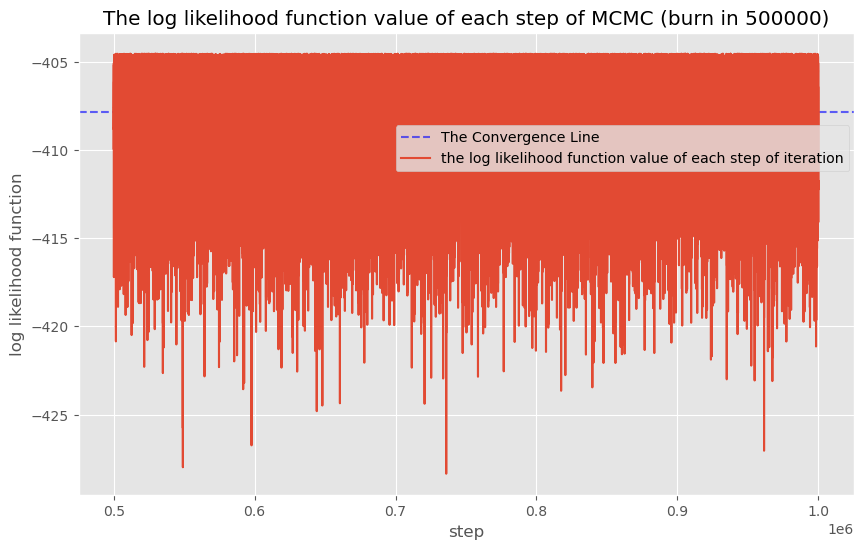

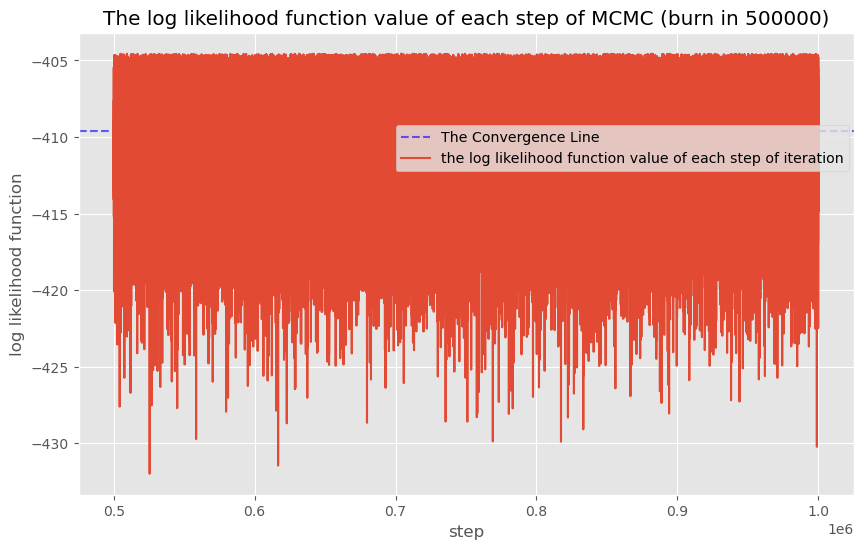

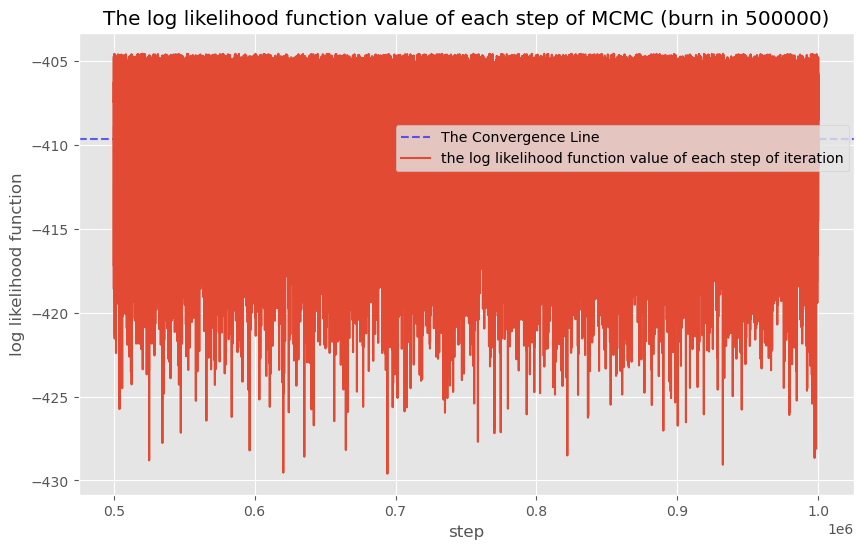

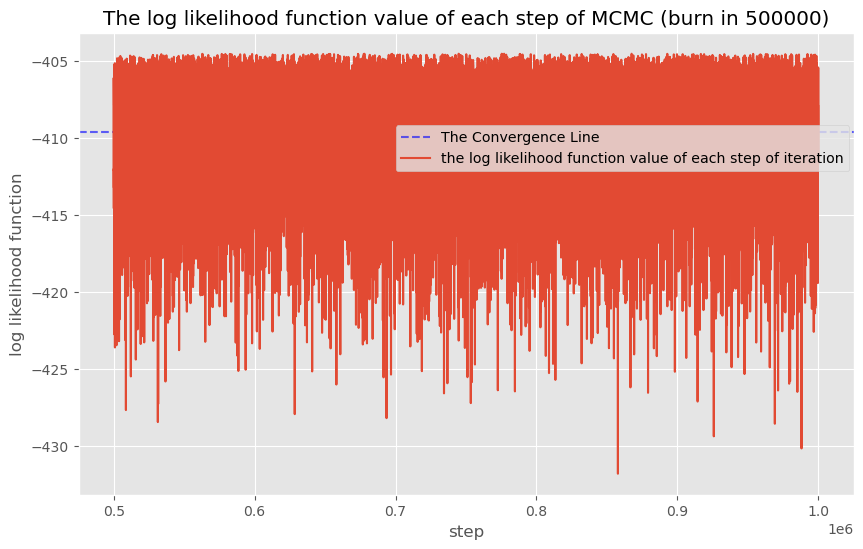

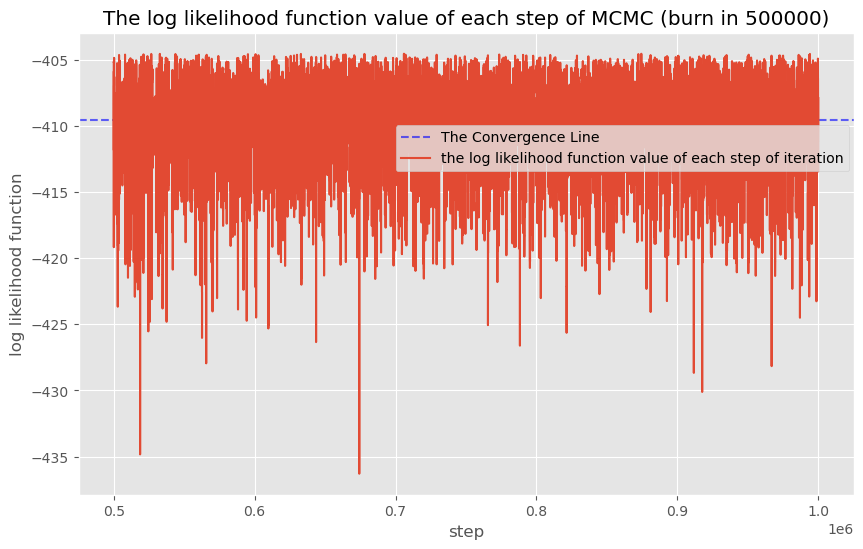

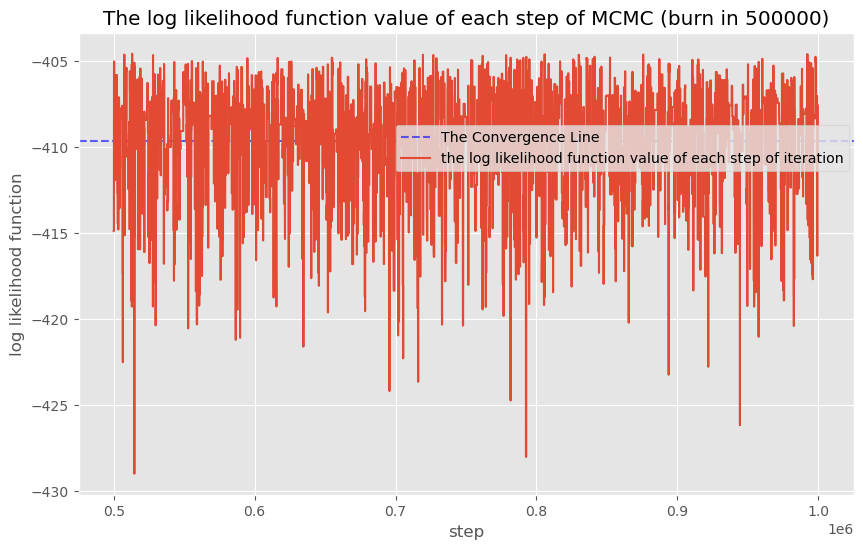

In [22]:
for Res_i in Res:
    sd = Res_i["PD_sd"]
    Vts.targetDis_step_plot(
        Thetas=Res_i["Thetas"], 
        rho=L_Gen.Log_Likelihood, 
        target_type="log likelihood function", 
        burn_in=500000, 
        figsize=(10,6),
        Saving_address=f"./Implementation_Images/Gaussian2D/MHMCMC/likelihood_plot_zoom_in sd={sd}.png",
        # zoom_size=1000
    )

In [22]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    ac = Res_G_SF["Acceptance_Rate"]
    time = Res_G_SF["Run_Times"][-1]
    print(f"When sd = {sd}, acceptance rate = {ac}, time taken {time}")

When sd = [0.005, 0.01], acceptance rate = 0.325655, time taken 1848.8659535000002


## Hamiltonian MCMC

### Initializing the list to collect the outputs of the MCMC algorithm

In [10]:
Res_H = []

In [11]:
# Loading the pre outputs
data_folder = "Datas/Data_40bins_100000scale_Gaussian_H/"
for name in os.listdir(data_folder):
    data_dir = os.path.join(data_folder, name)
    Res_H.append(Sts.Loading_Data(data_dir))

### Applying MCMC algorithm on the likelihood funciton

In [14]:
steps = 100000

In [13]:
for L in [4, 6, 8]:
    # for epsilon in [0.004, 0.005, 0.006]:
    epsilon = 0.0065
    Prop_H = PDs.HamiltonianProposalFunction(rho=L_Gen.Log_Likelihood, epsilon=epsilon, L=L, log_likelihood=True)
    MHMC_SF = MHMC(rho=Prop_H.U, log_likelihood=True)
    Res_H_i = MHMC_SF.generate(
        theta0=[0.5 for _ in range(2)],
        ProposalFunction=Prop_H,
        steps=steps,
        OutputRunTime=100,
        MaxTime=600
    )
    Res_H_i["PF_epsilon"] = epsilon
    Res_H_i["PF_L"] = L
    Res_H.append(Res_H_i)

In [28]:
for k in range(len(Res_H)):
    epsilon = Res_H[k]["PF_epsilon"]
    L = Res_H[k]["PF_L"]
    Saving_dir = f"Datas/Data_40bins_100000scale_Gaussian_H/Res_G_SF(epsilon={epsilon}, L={L}).npz"
    Sts.Saving_Data(Res_H[k], FileName=Saving_dir)

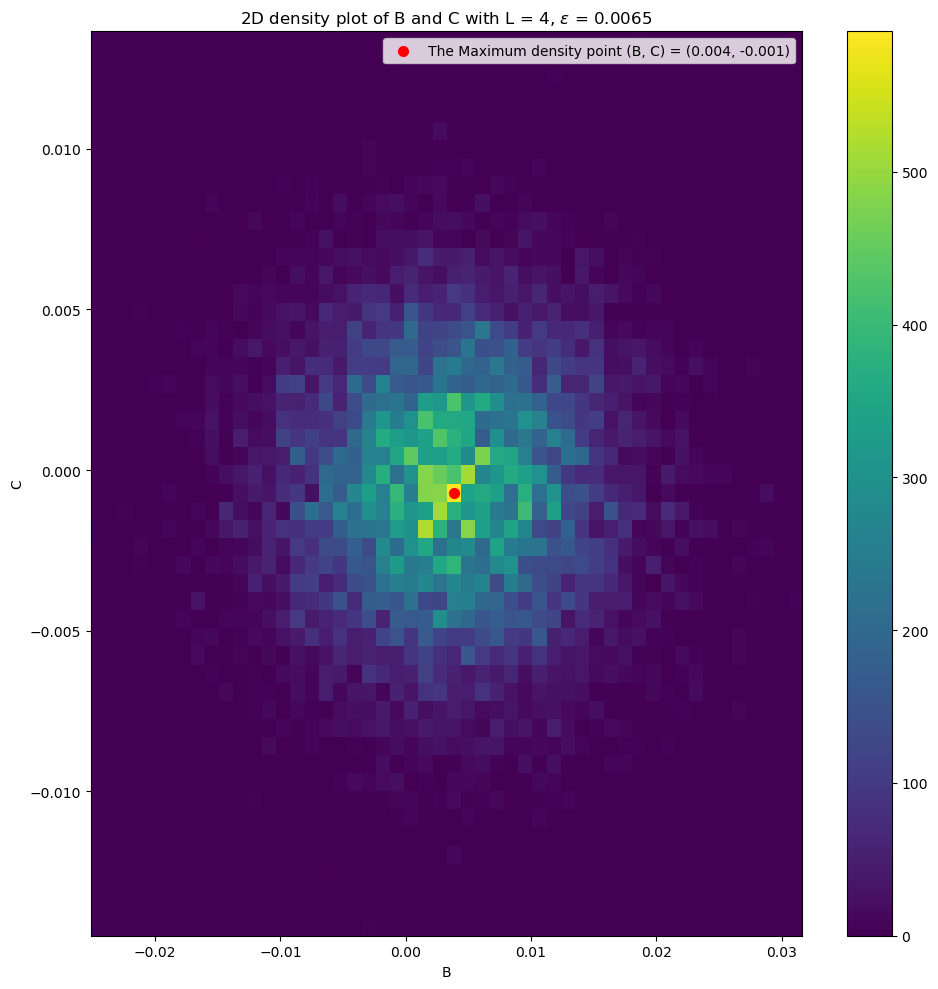

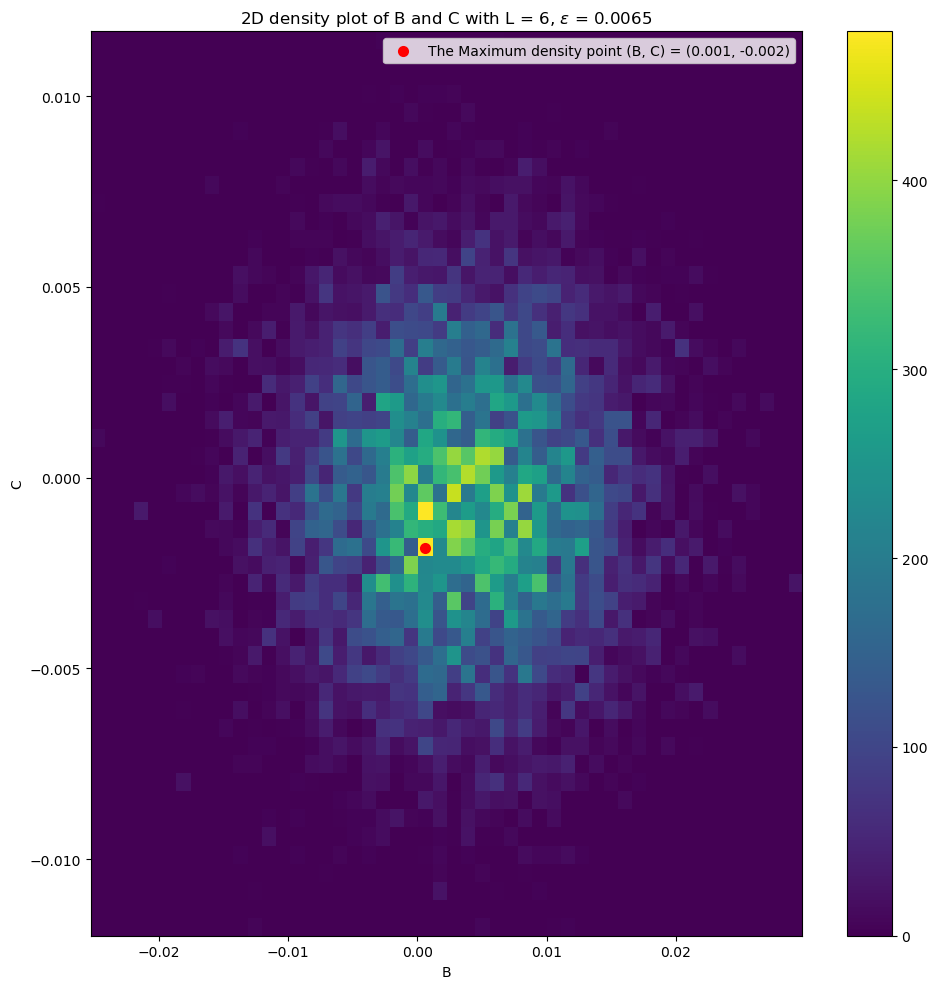

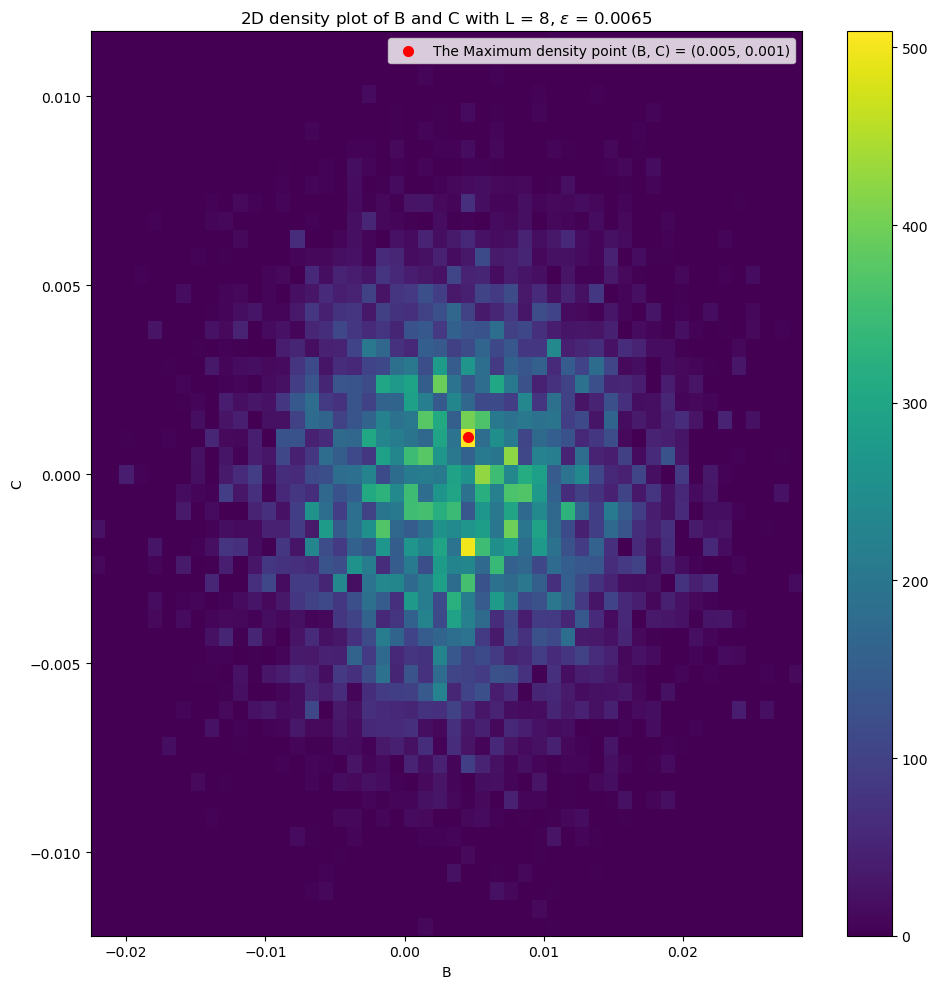

In [17]:
for Res_i in Res_H:
    epsilon = Res_i["PF_epsilon"]
    L = Res_i["PF_L"]
    Vts.density_plot(
        Res_i["Thetas"], 
        bins=50,
        burn_in=10000,
        credible_region=0,
        x_name="B",
        y_name="C",
        label = f" with L = {L}, $\epsilon$ = {epsilon}",
        alpha=1,
    )

c:\Users\91464\Nutstore\1\Nutstore\MLBD\PHYS70023\Coding\MCMC_DZ\MCMC\Visualization_tools.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


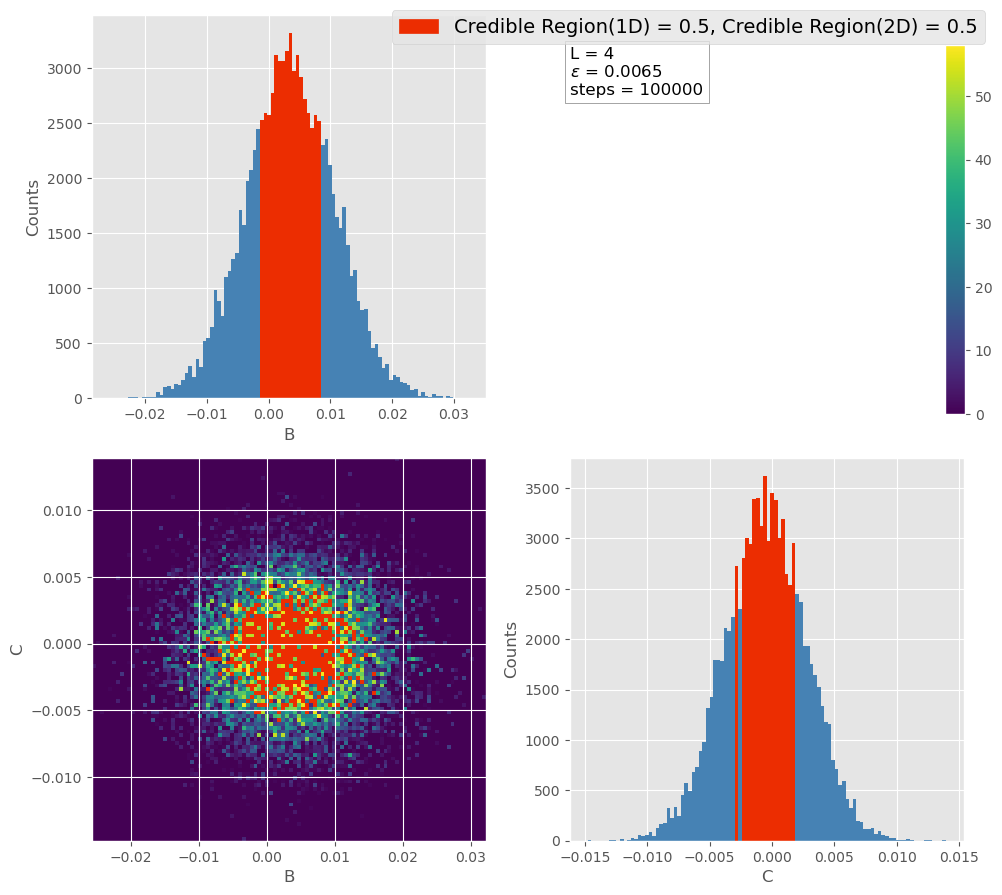

c:\Users\91464\Nutstore\1\Nutstore\MLBD\PHYS70023\Coding\MCMC_DZ\MCMC\Visualization_tools.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


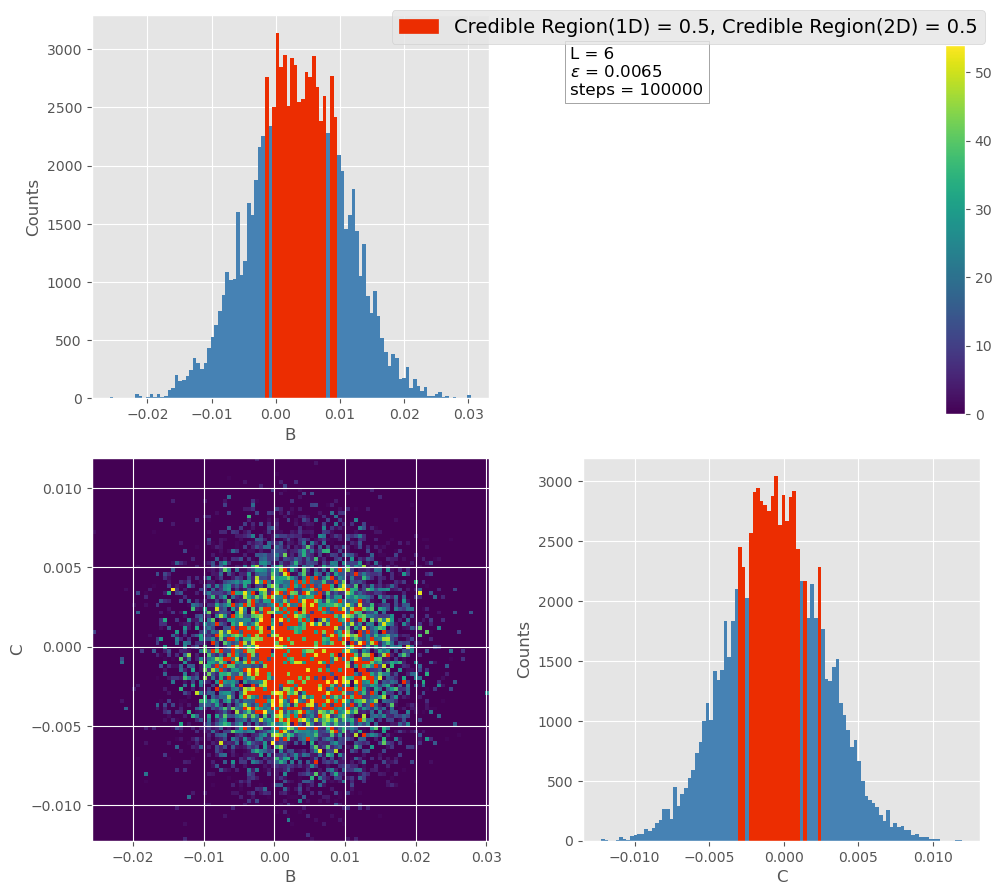

c:\Users\91464\Nutstore\1\Nutstore\MLBD\PHYS70023\Coding\MCMC_DZ\MCMC\Visualization_tools.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


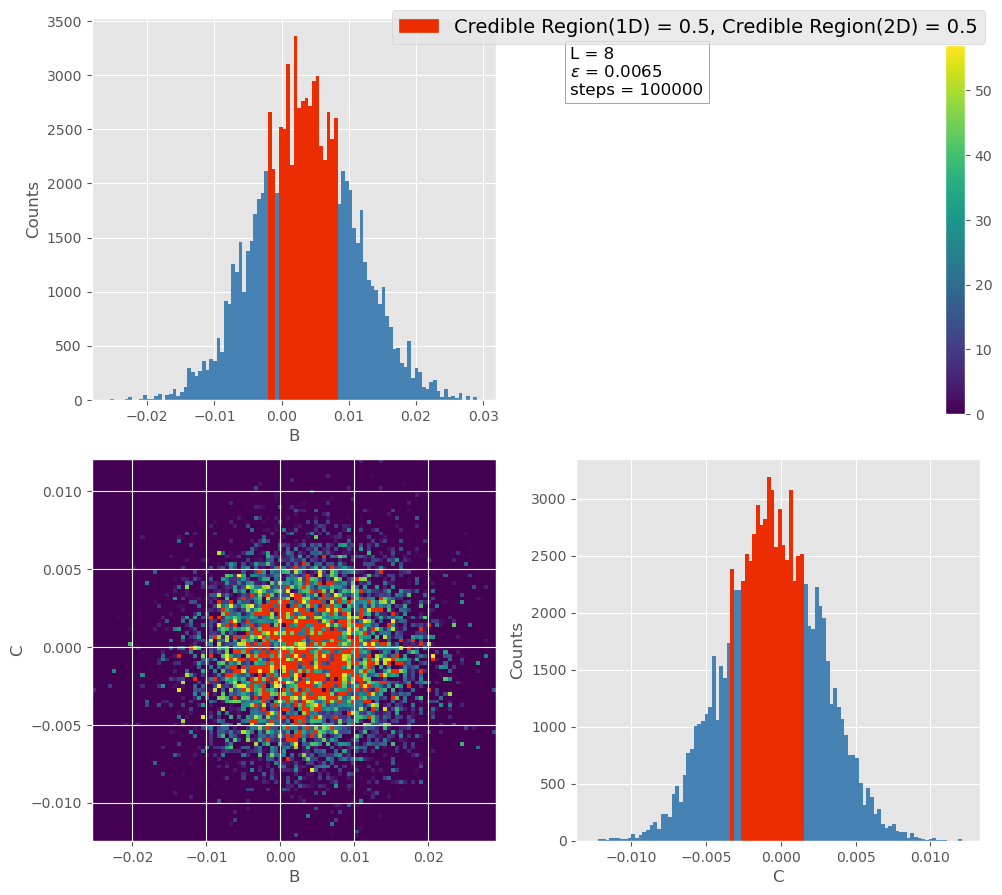

In [19]:
for Res_i in Res_H:
    epsilon = Res_i["PF_epsilon"]
    L = Res_i["PF_L"]
    _ = Vts.density_plots(
        Res_i["Thetas"],
        plot_axis=[0, 1],
        bins=100,
        burn_in=5000,
        axis_name=["B", "C"],
        cr_1D=0.5,
        cr_2D=0.5,
        information=f"L = {L}\n$\epsilon$ = {epsilon}\nsteps = {steps}"
    )


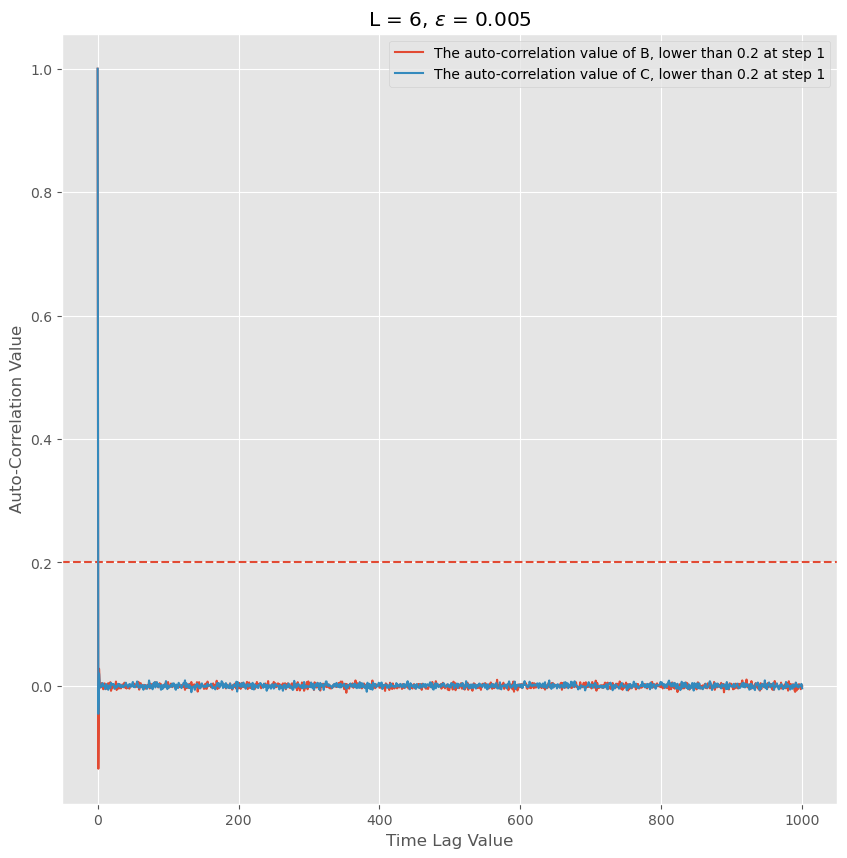

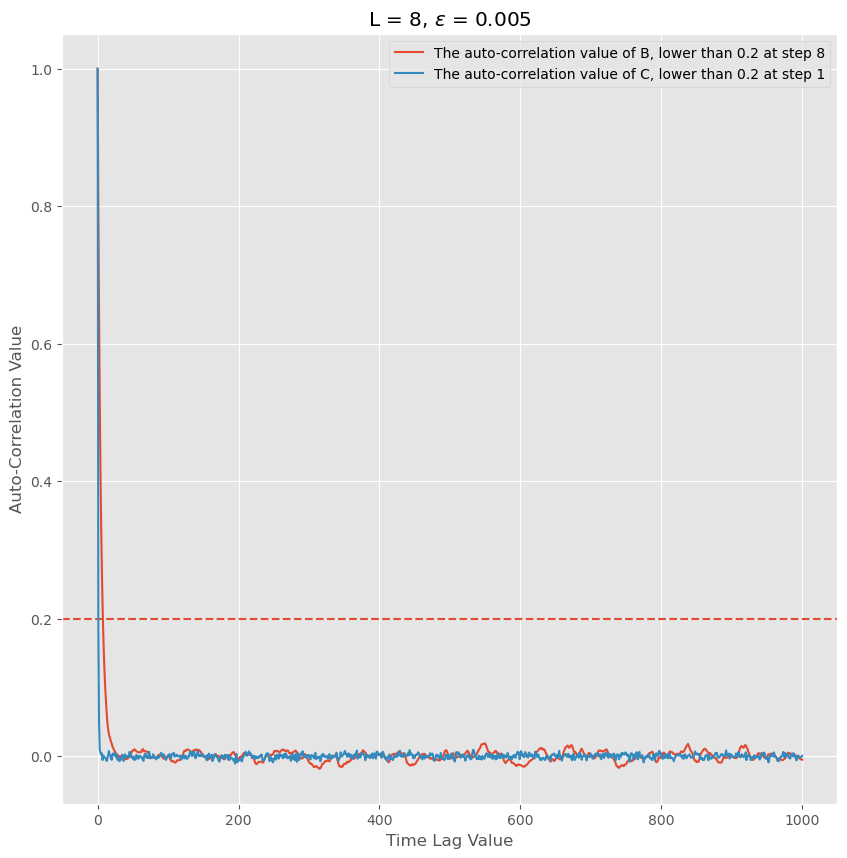

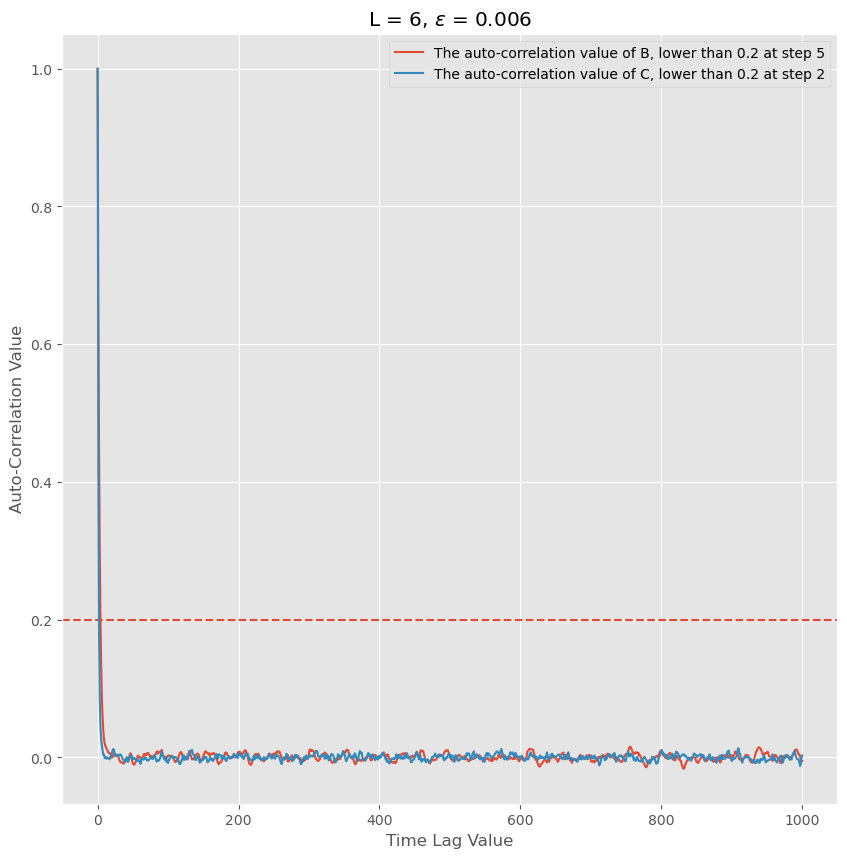

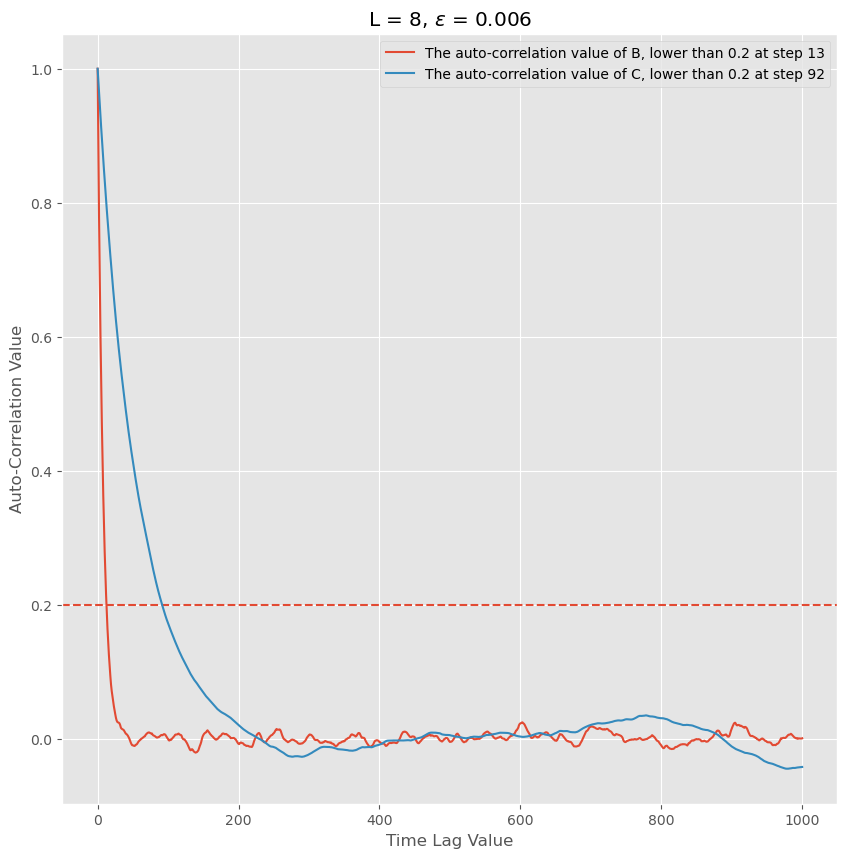

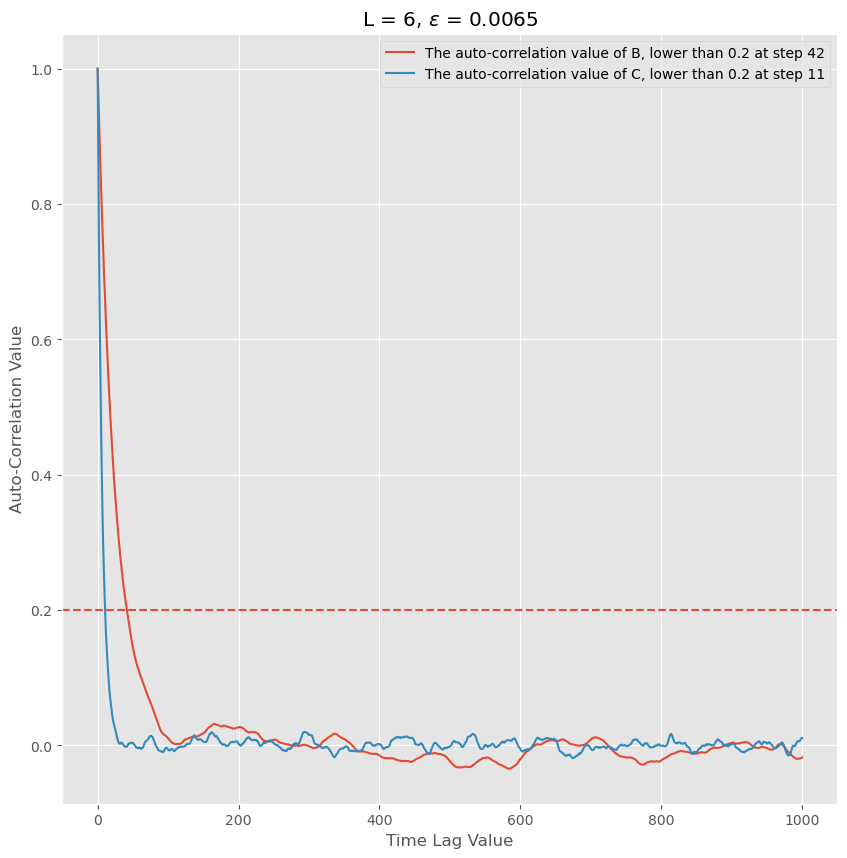

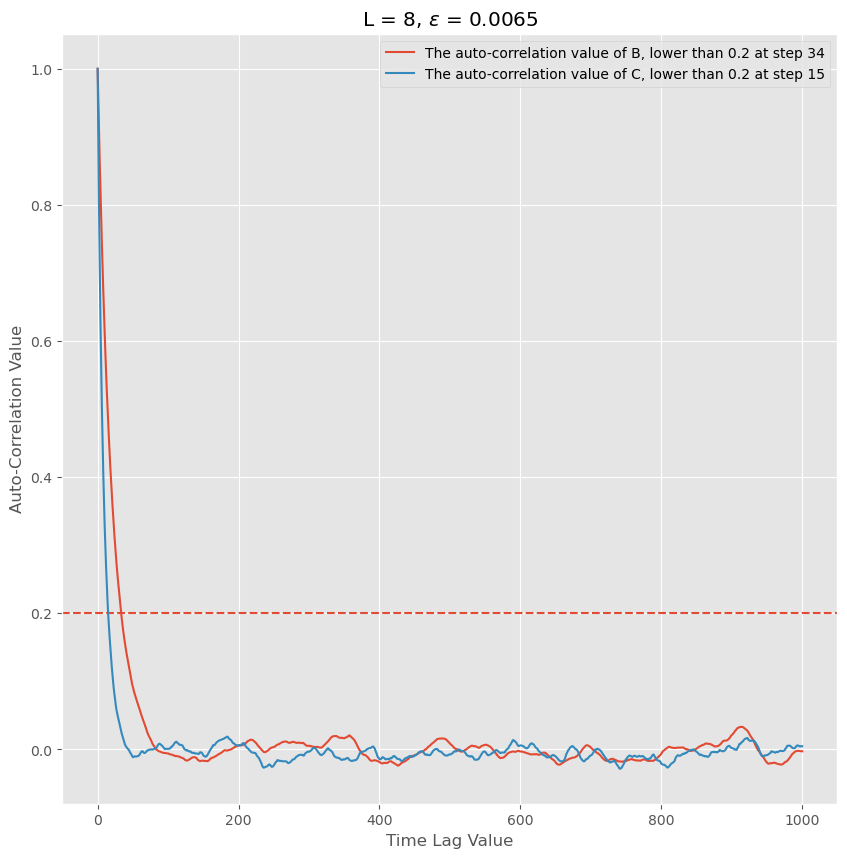

In [15]:
for Res_i in Res_H:
    epsilon = Res_i["PF_epsilon"]
    L = Res_i["PF_L"]
    Vts.auto_corr_plot(Thetas=Res_i["Thetas"], plot_nth_theta=[0,1], theta_index=["B", "C"], max_time_lag=1000, data_range=[1000, steps], Threshold=0.2, set_title=f"L = {L}, $\epsilon$ = {epsilon}")

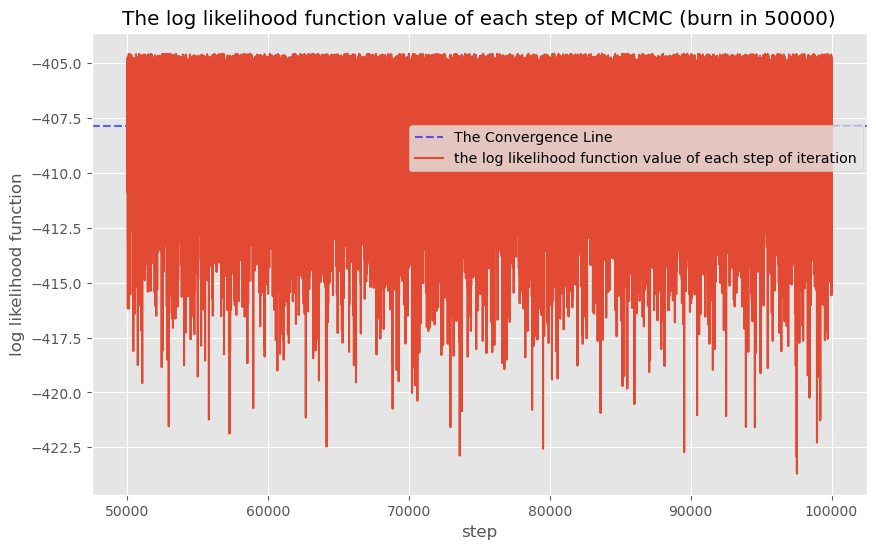

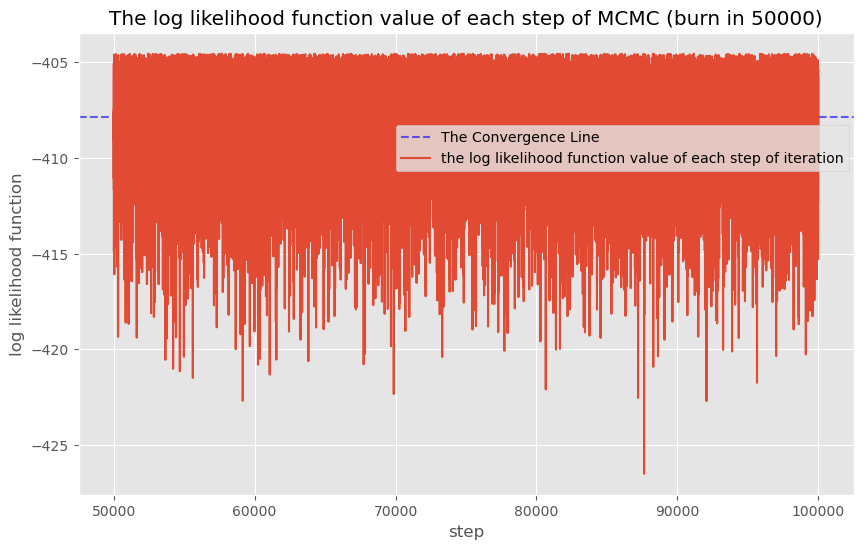

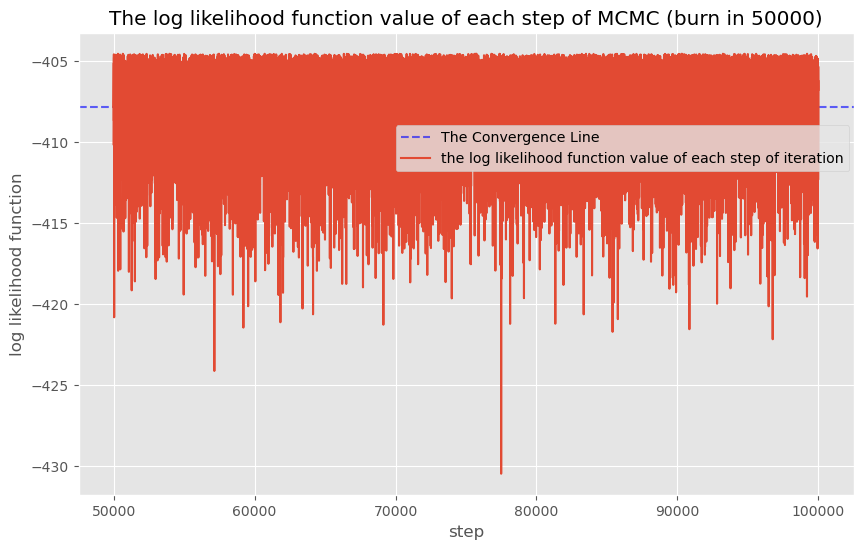

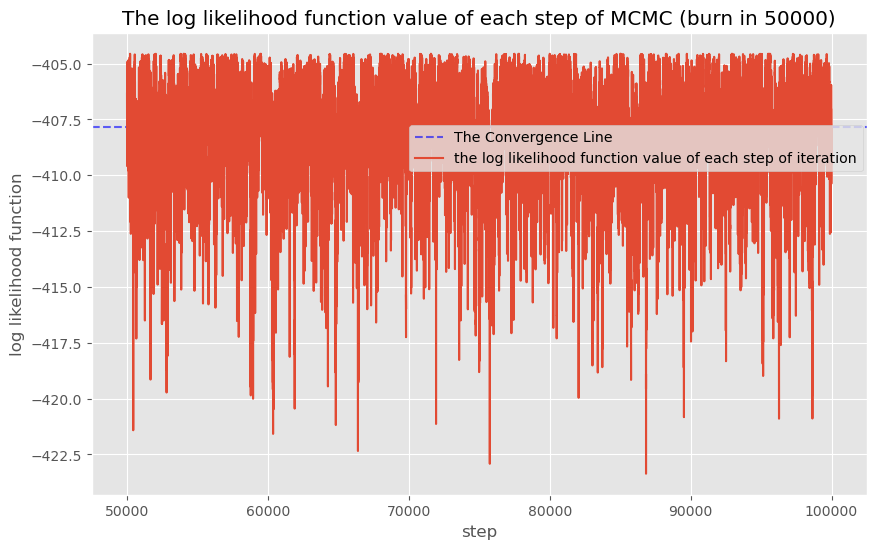

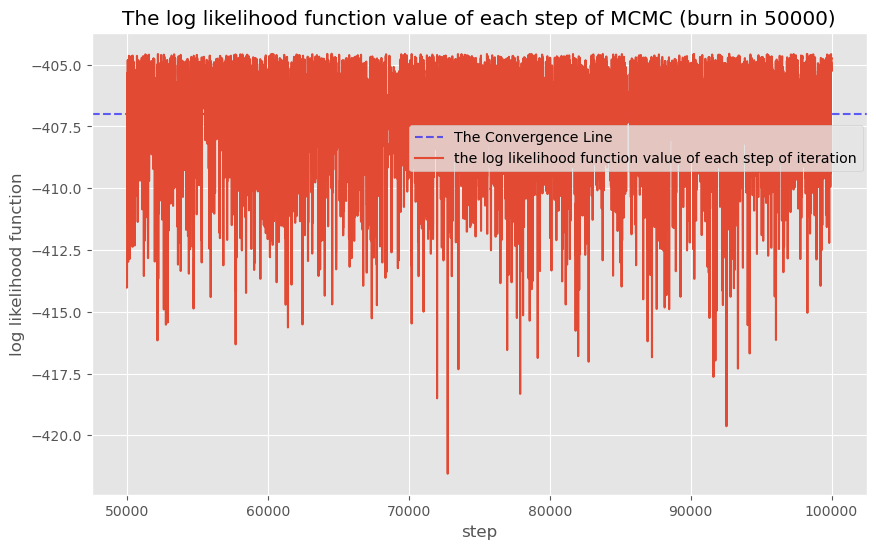

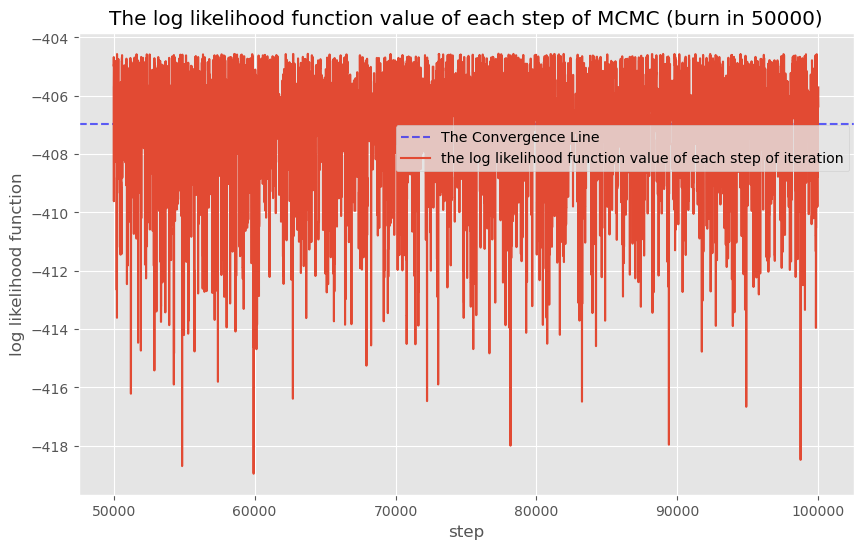

In [23]:
for Res_H_i in Res_H:
    epsilon = Res_H_i["PF_epsilon"]
    L = Res_H_i["PF_L"]
    Vts.targetDis_step_plot(
        Thetas=Res_H_i["Thetas"], 
        rho=L_Gen.Log_Likelihood, 
        target_type="log likelihood function", 
        burn_in=50000, 
        figsize=(10,6),
        # zoom_size=1000,
        Saving_address=f"./Implementation_Images/Gaussian2D/HMCMC/likelihood_plot_zoom_in epsilon={epsilon}, L={L}.png"
    )

In [21]:
for Res_i in Res_H:
    L = Res_i["PF_L"]
    epsilon = Res_i["PF_epsilon"]
    ac = Res_i["Acceptance_Rate"]
    time = Res_i["Run_Times"][-1]
    print(f"When L = {L}, $\epsilon$ = {epsilon}, acceptance rate = {ac}, time taken {time}")

When L = 4, $\epsilon$ = 0.0065, acceptance rate = 0.15659, time taken 255.8070737999999
When L = 6, $\epsilon$ = 0.0065, acceptance rate = 0.10857, time taken 339.91927450000003
When L = 8, $\epsilon$ = 0.0065, acceptance rate = 0.08368, time taken 429.0539331
